# Final project

In [1]:
import sqlite3 as sql
import pandas as pd
import plotly.express as px
import numpy as np
from scipy.stats import zscore
import plotly.io as pio
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import regularizers
import seaborn as sns
import tensorflow as tf
from tensorflow import math as tfmath
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Part 1
### Graph the number of accidents across time
##### Get the data using sqlite3 module

Get the month, year, and count of collisions. Remove entries from 2021 because there is a lot of missing data.

In [2]:
# get the data with sqlite
# remove entries from 2021 because there is a lot of missing data from that year
con = sql.connect("switrs.sqlite")
cur = con.cursor()

query1 = """SELECT strftime('%Y-%m',collision_date) AS date, strftime('%Y', collision_date) as year, 
COUNT(collision_date) as count 
FROM collisions 
WHERE strftime('%Y', collision_date) != '2021' 
GROUP BY date 
ORDER BY date"""

data = pd.read_sql(query1, con)

##### Create the plot using plotly

How to interact with the plot:
- The plots shows collisions from 2001 to 2020. You can use the buttons to visualize collisions over the last 5 years, the last 1 year, or the last 6 month.
- The slider under the graph can be used to vizualize any custom time range. To choose this custom time range, move the left and right sliders to your desired time frame.
- You can hover over the data points in the graph with your cursor to see the month and year when those collisions occured.

In [3]:
fig = px.line(data, x="date", y ="count", title="Accidents in California from 2001 to 2020",
              labels={
                  "date":"month and year of accident",
                  "count":"accident frequency"
              })

# Change the xsticks with years
fig.update_layout(xaxis=dict(tickmode="array", tickvals=data['date'][::12], ticktext=data['year'][::12]))
fig.update_traces(hovertemplate="%{x|%b %Y}")

# add a slider and buttons
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=6, step="month", label="6 months", stepmode="backward"),
                      dict(count=1, step="year", label="1 year", stepmode="backward"),
                      dict(count=5, step="year", label="5 years", stepmode="backward"),
                      dict(step="all")
                      
                      ])
    )
)
fig.show()

The plot shows us that there have been oscilations with periods of more (e.g., 2004) and less (e.g., 2012) accidents across time.

### Graph the frequency of collision severity
##### Get the data using sqlite

Select the year, and count of the different collision severity classes

In [4]:
query2 = """
SELECT strftime('%Y', collision_date) as year, collision_severity, 
COUNT(collision_severity) as severity_count 
FROM collisions 
WHERE strftime('%Y',collision_date) != '2021' 
AND collision_severity != 'N' 
GROUP BY year, collision_severity
"""

data2 = pd.read_sql(query2,con)
pd.options.display.max_rows=10


##### Create the histogram using plotly

How to interact with this graph:
- The legend contains the different collision severity levels. You can click any category in the legend to remove it from the histogram
- You can hover over the histogram bar and see the category, year and frequency of that collison severity type

In [5]:
fig2 = px.histogram(data2, x='year', y='severity_count', barmode="group",
              color='collision_severity', 
              title="Severity of accidents from 2001 to 2020",
              labels= {
                  'year': 'Year',
                  'severity_count': 'Frequency',
                  'collision_severity': 'Collision Severity'
              })
fig2.show()

From the graph displaying the severity of accidents we can see that accidents where there is only damage of property are by far the most common accidents. The second most common is accidents resulting in pain. The third most common are accidents resulting in non severe injury (called other injury in the data). The fourth most commno is severe injusry and the fifth is fatal collisions.

# Part 2
### Build neural network that predicts accident severity

The next part of this assignment will be about building a neural network which can predict collision severity type.

Included features:
- collision_time: Time crash occured (only used hour of day, processed as numerical)
- year: Year accident took place (categorical)
-month: Month the accident took place (categorical)
- chp_beat_type: Location of crash (categorical)
- distance: Distance of the crash from the intersection with secondary road (numerical)
- direction: Direction of the crash from the intersection with the secondary roadway (categorical)
- weather1: Weather condition at the time of the crash (categorical)
- party_count: Number of vehicles involved in crash (numerical)
- primary_coll_factor: Primary collision factor (categorical)
- type_of_collision: The general type of crash (categorical)
- motor_vehicle_involved_with: Describes what, in conjunction with a motor vehicle in-transport, produced the first injury or damage-causing event, on or off the road (categorical)
- road_surface: Roadway surface condition at the time of the crash (categorical)
- road_cond_1: Roadway condition at the time of the crash (categorical)
- lighting: Lighting conditions at the crash location and the time of the crash (categorical)
- bicycle_accident: Indicates whether the crash involved a bicycle (binary)
- motorcycle_accident: Indicates whether the crash involved a motorcycle (binary)
- truck_accident: 	Indicates whether the crash involved a big truck (binary)

##### Get the data using sqlite


In [6]:
# select all columns, randomly order the data and select 10,000 data points (using all data points is too much to process)
queryNN = """
SELECT collision_severity,
collision_time,
strftime('%Y', collision_date) as year,
strftime('%m', collision_date)as month,
chp_beat_type,
distance,
weather_1,
party_count,
primary_collision_factor,
type_of_collision,
motor_vehicle_involved_with,
road_surface,
road_condition_1,
lighting,
bicycle_collision,
motorcycle_collision,
truck_collision
FROM collisions
ORDER BY RANDOM()
LIMIT 10000
"""

dataNN = pd.read_sql(queryNN,con)
display(dataNN.iloc[:10])

,collision_severity,collision_time,year,month,chp_beat_type,distance,weather_1,party_count,primary_collision_factor,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,bicycle_collision,motorcycle_collision,truck_collision
0,other injury,19:00:00,2019,09,not chp,0.0,clear,2,vehicle code violation,rear end,bicycle,dry,normal,dark with street lights,1,0,0
1,property damage only,17:40:00,2018,04,interstate,1000.0,clear,2,vehicle code violation,sideswipe,other motor vehicle,dry,normal,daylight,0,0,1
2,property damage only,12:30:00,2015,05,interstate,200.0,clear,1,other than driver,hit object,other object,dry,normal,daylight,0,0,0
3,property damage only,00:46:00,2007,01,not chp,0.0,clear,1,vehicle code violation,hit object,fixed object,dry,normal,dark with street lights,0,0,0
4,severe injury,17:32:00,2018,12,not chp,102.0,clear,2,vehicle code violation,pedestrian,pedestrian,dry,normal,dark with street lights,0,0,0
5,property damage only,23:10:00,2003,09,county road area,22.0,clear,2,vehicle code violation,rear end,other motor vehicle,dry,normal,dark with no street lights,0,0,0
6,property damage only,13:43:00,2002,11,not chp,15.0,clear,2,vehicle code violation,rear end,other motor vehicle,dry,normal,daylight,0,0,0
7,property damage only,10:39:00,2006,01,county road area,60.0,cloudy,2,vehicle code violation,rear end,other motor vehicle,wet,normal,daylight,0,0,0
8,property damage only,21:10:00,2005,02,state route,100.0,cloudy,3,vehicle code violation,rear end,other motor vehicle,wet,normal,dark with street lights,0,0,0
9,property damage only,08:30:00,2002,02,safety services program,0.0,clear,2,other improper driving,sideswipe,other motor vehicle,dry,normal,daylight,0,0,0


### Clean the data
##### Get the hour of the day and transform to float

In [7]:
# get hour of day from the time column
dataNN["collision_time"] = dataNN["collision_time"].str.split(":").str[0].astype(float)

##### One hot encode categorical variables

In [8]:
# one hot encode variables
data_rows_encode = ["year","month","chp_beat_type", "weather_1","primary_collision_factor", 
               "type_of_collision", "motor_vehicle_involved_with", "road_surface",
               "road_condition_1","lighting"]


data_dummies = pd.get_dummies(dataNN[data_rows_encode])
label_dummies = pd.get_dummies(dataNN["collision_severity"])

#display(data_dummies)
#display(label_dummies)


##### Create df with the data to use in the neural network and transform into a numpy array

In [9]:
# drop rows that were one hot encoded and the labels and merge df with dummie variables
final_data = dataNN.drop(data_rows_encode + ["collision_severity"],axis=1).merge(data_dummies,left_index=True, right_index=True)

# fill na's for collision time with the mean collision time
final_data["collision_time"] = final_data["collision_time"].fillna(value=np.mean(final_data["collision_time"]))

# normalize the numeric variables (collision_time, distance, party_count)
numerical = ["collision_time", "distance", "party_count"]
final_data[numerical] = final_data[numerical].apply(zscore)

# transform df to array
data_array_NN = final_data.to_numpy()
labels_array_NN = label_dummies.to_numpy()
print(labels_array_NN.shape)
print(data_array_NN.shape)

(10000, 5)
(10000, 96)


##### Build neural network

In [10]:
# get testing and training set
from sklearn.model_selection import train_test_split

# Make sure all numbers in the array are floats
data_array_NN = np.array(data_array_NN).astype(np.float32)
labels_array_NN = np.array(labels_array_NN).astype(np.float32)

# split the data using train_test_split with a training set of 70% of the data and a testing set containing 30%
X_train, X_test, y_train, y_test = train_test_split(data_array_NN, labels_array_NN, train_size=0.7)


##### Version 1
This model contains two dense layers which use a ReLu activation function, the first containing 100 nodes and the second with 200 nodes. The model contains an output layer using a softmax activation function.

From the plots showing the loss and the accuracy between the training and testing data we can see that the model is overfitting the training data.

c:\Users\miade\miniconda3\envs\SP\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5730 - loss: 1.0943 - val_accuracy: 0.6357 - val_loss: 0.9372
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6467 - loss: 0.8840 - val_accuracy: 0.6543 - val_loss: 0.9129
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6405 - loss: 0.8673 - val_accuracy: 0.6443 - val_loss: 0.9230
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6534 - loss: 0.8487 - val_accuracy: 0.6471 - val_loss: 0.9021
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6572 - loss: 0.8360 - val_accuracy: 0.6500 - val_loss: 0.9116
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6584 - loss: 0.8326 - val_accuracy: 0.6171 - val_loss: 0.9238
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6555 - loss: 0.8297 - val_accuracy: 0.6357 - val_loss: 0.9067
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6682 - loss: 0.8017 - val_accuracy: 0.6429 - val_loss

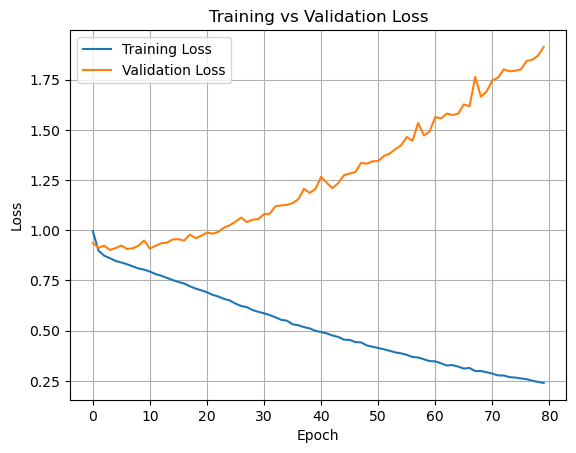

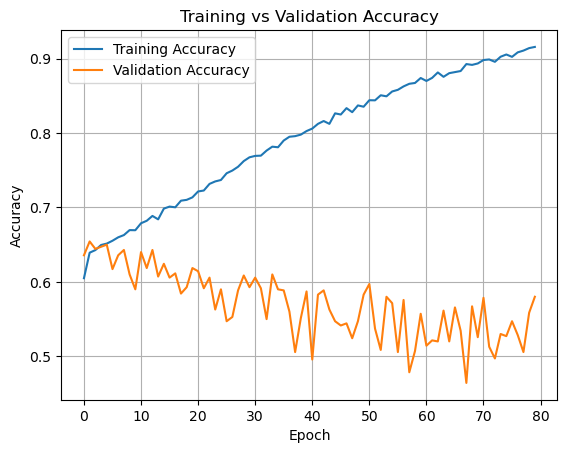

In [11]:

# Make a fully connected network
model = models.Sequential()

# Create the hidden layer with relu activations
model.add(layers.Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(units=200, activation='relu'))

model.add(layers.Dense(units=5, activation='softmax'))

# Compile the network with the appropriate loss function and keep track of accuracy
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, batch_size=100, epochs=80, validation_split=.1)

# See how the model scored
loss, accuracy  = model.evaluate(X_test, y_test)

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##### Version 2

In the second version, to reduce the amount of overfitting from the model I added a dropout layer of 40% before the second dense layer. 

After this implmentation the model still overfit but after more iterrations than in the first model.

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5678 - loss: 1.1223 - val_accuracy: 0.6314 - val_loss: 0.9530
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6190 - loss: 0.9423 - val_accuracy: 0.6329 - val_loss: 0.9299
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6336 - loss: 0.9257 - val_accuracy: 0.6529 - val_loss: 0.9119
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6450 - loss: 0.9100 - val_accuracy: 0.6229 - val_loss: 0.9268
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6424 - loss: 0.8845 - val_accuracy: 0.6486 - val_loss: 0.8996
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6435 - loss: 0.8693 - val_accuracy: 0.6514 - val_loss: 0.9001
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6556 - loss: 0.8518 - val_accuracy: 0.6471 - val_loss: 0.8989
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6332 - loss: 0.8900 - val_accuracy: 0.6443 - val_loss

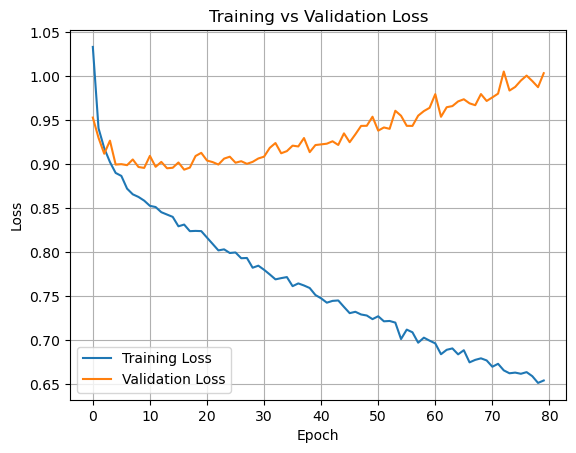

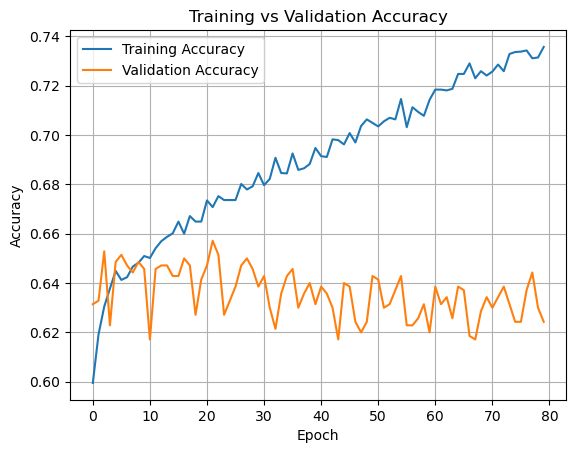

In [12]:

# Make a fully connected network
model = models.Sequential()

# Create the hidden layer with relu activations
model.add(layers.Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))

# To further avoid overfitting add a dropout layer before the dense layers
model.add(layers.Dropout(rate=0.4))

model.add(layers.Dense(units=200, activation='relu'))

model.add(layers.Dense(units=5, activation='softmax'))

# Compile the network with the appropriate loss function and keep track of accuracy
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, batch_size=100, epochs=80, validation_split=.1)

# See how the model scored
loss, accuracy  = model.evaluate(X_test, y_test)

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##### Version 3

To further reduce overfitting, I added L1 regulariszation to the weights in the dense layer.

This greatly reduced overfitting in the model.

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5322 - loss: 3.1122 - val_accuracy: 0.6171 - val_loss: 2.1949
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6145 - loss: 2.0037 - val_accuracy: 0.6200 - val_loss: 1.5891
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6244 - loss: 1.4803 - val_accuracy: 0.6171 - val_loss: 1.3342
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6263 - loss: 1.2715 - val_accuracy: 0.6386 - val_loss: 1.1961
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6238 - loss: 1.1743 - val_accuracy: 0.6429 - val_loss: 1.1429
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6247 - loss: 1.1127 - val_accuracy: 0.6386 - val_loss: 1.0930
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6256 - loss: 1.0945 - val_accuracy: 0.6429 - val_loss: 1.0682
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6301 - loss: 1.0534 - val_accuracy: 0.6429 - val_loss

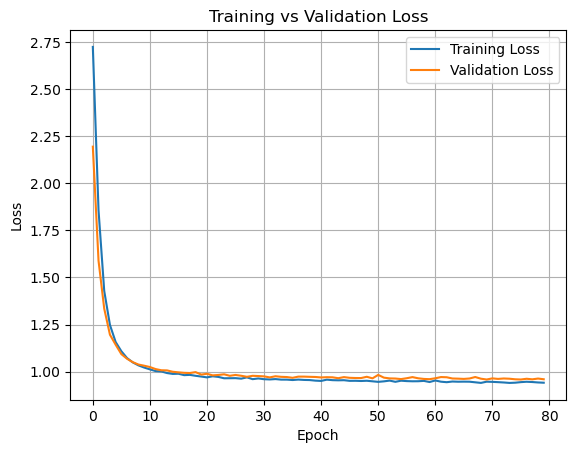

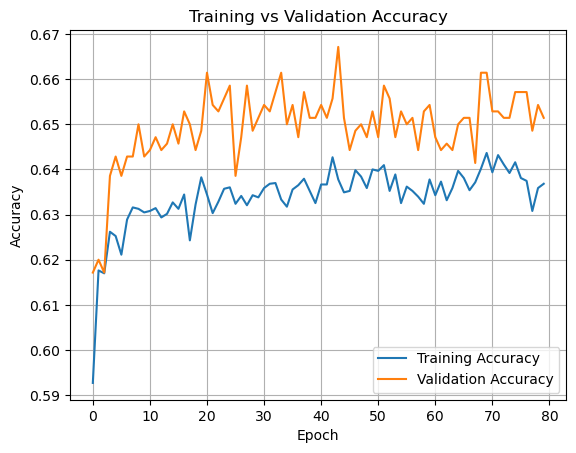

In [13]:

# Make a fully connected network
model = models.Sequential()

# Create the hidden layer with sigmoid activations
# to stop the model from overfitting add L1 regularization to the weights of the dense layers
model.add(layers.Dense(units=100, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu', input_shape=(X_train.shape[1],)))

# To further avoid overfitting add a dropout layer before the dense layers
model.add(layers.Dropout(rate=0.4))
model.add(layers.Dense(units=200, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu'))

model.add(layers.Dense(units=5, activation='softmax'))

# Compile the network with the appropriate loss function and keep track of accuracy
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, batch_size=100, epochs=80, validation_split=.1)

# See how the model scored
loss, accuracy  = model.evaluate(X_test, y_test)

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##### Version 4

In this next version I tried to add a third dense layer with 200 nodes to improve the networks ability to classify. I also added a 20% dropout layer before this third layer. This dropout layer was only20% because it is closest to the output layer, so I wanted the model to use more of the nodes to increase classification accuracy.

This did not help increase the accuracy.

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5883 - loss: 4.9698 - val_accuracy: 0.6186 - val_loss: 3.0683
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6160 - loss: 2.6581 - val_accuracy: 0.6200 - val_loss: 1.7525
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6106 - loss: 1.6158 - val_accuracy: 0.6171 - val_loss: 1.3432
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6077 - loss: 1.3082 - val_accuracy: 0.6229 - val_loss: 1.2149
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6271 - loss: 1.1895 - val_accuracy: 0.6314 - val_loss: 1.1580
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6290 - loss: 1.1229 - val_accuracy: 0.6343 - val_loss: 1.1195
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6277 - loss: 1.1041 - val_accuracy: 0.6357 - val_loss: 1.0917
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6271 - loss: 1.0705 - val_accuracy: 0.6386 - val_loss

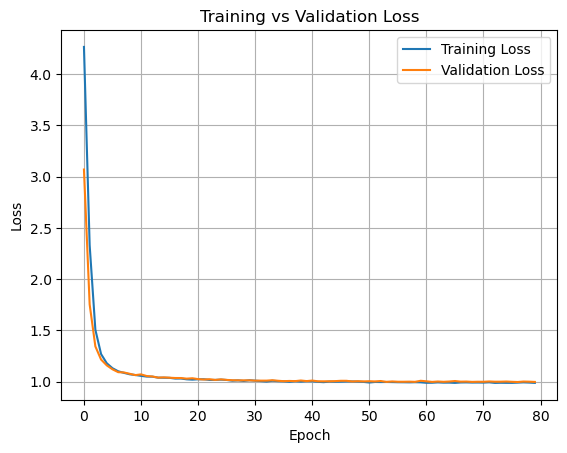

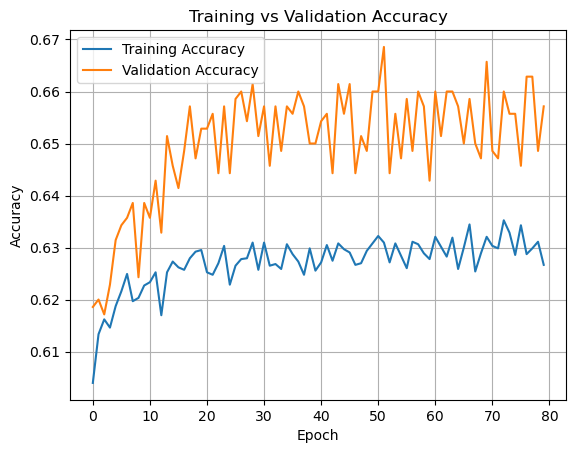

In [14]:

# Make a fully connected network
model = models.Sequential()

# Create the hidden layer with sigmoid activations
# to stop the model from overfitting add L1 regularization to the weights of the dense layers
model.add(layers.Dense(units=100, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu', input_shape=(X_train.shape[1],)))


# To further avoid overfitting add a dropout layer before the dense layers
model.add(layers.Dropout(rate=0.4))
model.add(layers.Dense(units=200, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu'))

model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=200, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu'))

model.add(layers.Dense(units=5, activation='softmax'))

# Compile the network with the appropriate loss function and keep track of accuracy
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, batch_size=100, epochs=80, validation_split=.1)

# See how the model scored
loss, accuracy  = model.evaluate(X_test, y_test)

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##### Version 5

In this final version, I added batch normalization after every dense layer to attemps to improve prediciton accuracy. I hope that by shifting the mean and standard deviation of the standardised data, the model will better predict the testing data.

The validation accuracy did not improve, but on the first epoch the validation accuracy was very high compared to previous versions.

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3399 - loss: 6.2842 - val_accuracy: 0.6100 - val_loss: 5.3061
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5656 - loss: 5.1865 - val_accuracy: 0.6100 - val_loss: 4.6849
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6225 - loss: 4.5175 - val_accuracy: 0.6114 - val_loss: 4.1963
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6094 - loss: 4.0537 - val_accuracy: 0.6214 - val_loss: 3.7368
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6358 - loss: 3.5796 - val_accuracy: 0.6271 - val_loss: 3.3465
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6244 - loss: 3.2514 - val_accuracy: 0.6314 - val_loss: 2.9931
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6204 - loss: 2.8767 - val_accuracy: 0.6371 - val_loss: 2.6916
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6376 - loss: 2.5889 - val_accuracy: 0.6414 - val_loss

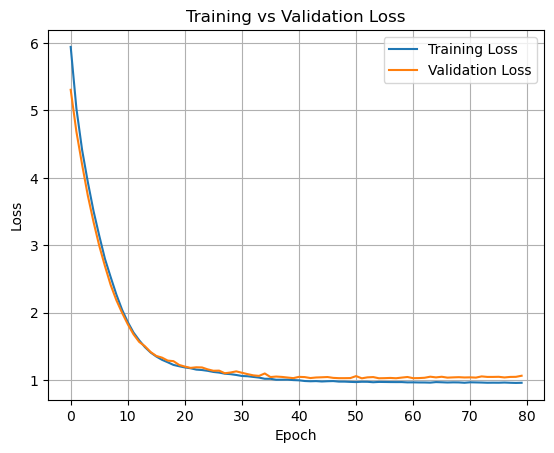

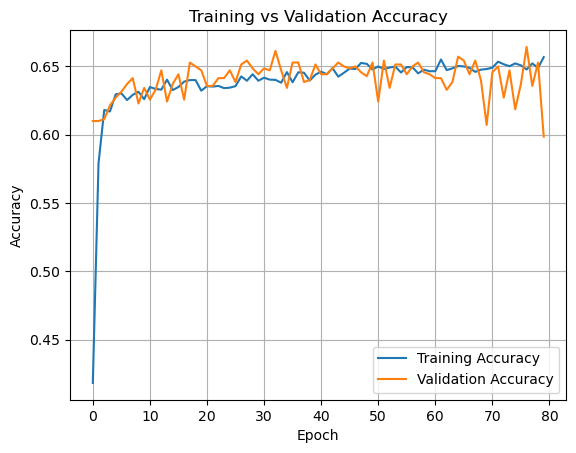

In [15]:

# Make a fully connected network
model = models.Sequential()

# Create the hidden layer with sigmoid activations
# to stop the model from overfitting add L1 regularization to the weights of the dense layers
model.add(layers.Dense(units=100, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu', input_shape=(X_train.shape[1],)))

# add batch normalization after the dense layer to find the most optimal normalization for the data
model.add(layers.BatchNormalization())

# To further avoid overfitting add a dropout layer before the dense layers
model.add(layers.Dropout(rate=0.4))
model.add(layers.Dense(units=200, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=200, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(units=5, activation='softmax'))

# Compile the network with the appropriate loss function and keep track of accuracy
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, batch_size=100, epochs=80, validation_split=.1)

# See how the model scored
loss, accuracy  = model.evaluate(X_test, y_test)

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##### Create a heat map 

The last step of this project will be creating a heat map to see how predicted classes compared to the real classes

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


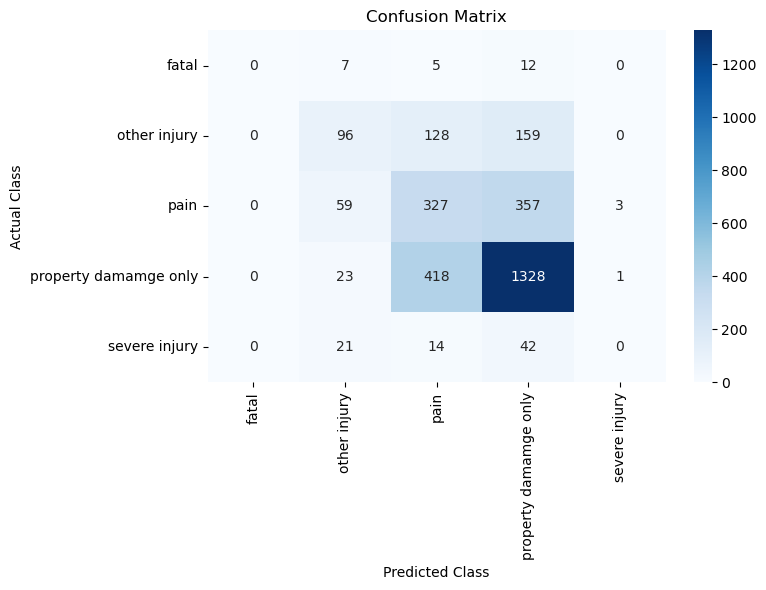

In [16]:

# Convert one-hot encoded y_test to class labels
y_true = tf.argmax(y_test, axis=1).numpy()

# Get predictions from the model and convert to class labels
y_pred_probs = model.predict(X_test)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()

# reassign class names
classes = ["fatal", "other injury", "pain", "property damamge only", "severe injury"]

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()



# Conclusion

The final model achieved a validation accuracy of approximately 64%. While the addition of regularization effectively reduced overfitting, increasing the model's complexity did not lead to improvements in validation performance. The low validation accuracy could be due to mutliple reasons. Firstly, this suggests that the features used to predict collision severity may not have been sufficiently informative to accurately distinguish between all severity classes. Secondly, the dataset exhibited class imbalance, with "property damage only" being the most frequently occurring category, and fatality being the least occuring. This imbalance is reflected in the model’s predictions, as the "property damage only" class was predicted with the highest accuracy, but was also the most predicted class generally. Furthermore, fatality was the class with the least predictions overall.